#### Setting the environment variables

In [1]:
import os, sys, warnings, platform

osname = platform.system()
print('Running on', osname)

if (osname == 'Windows'):
    # Definitions for Windows 10 instance
    os.environ["PYSPARK_PYTHON"] = "D:/Anaconda3/python"
    os.environ["PYSPARK_DRIVER_PYTHON"]="D:/Anaconda3/python"
    os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
    os.environ["JAVA_HOME"] = "C:/Program Files/Java/jdk1.8.0_251/jre"
    os.environ["SPARK_HOME"] = "D:/spark-2.4.4-bin-hadoop2.7"
    os.environ["HADOOP_HOME"] = "D:/spark-2.4.4-bin-hadoop2.7"
    os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
    sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
    sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")
else:
    # Definitions for EC2 Linux instance
    os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
    os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
    os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
    os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
    os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
    os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
    sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
    sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

Running on Linux


# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number. You can refer to notebook 1 for the steps involved here.

In [2]:
# Spark environment imports

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [3]:
# initialising the session with 14 GB driver memory

MAX_MEMORY = "14G"
spark = SparkSession \
    .builder \
    .appName("Notebook_2") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()
spark

In [4]:
# Spark session with 14 GB driver memory

spark.sparkContext.getConf().get('spark.driver.memory')

'14G'

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('float_format', '{:.4f}'.format)
pd.options.display.max_colwidth = 100
%matplotlib inline
plt.rcParams['font.size'] = '14'

In [6]:
%%time
# Loading the clean data

df = spark.read.parquet('task2_cleaned_df.parquet')
print('cleaned_df row count =', df.count())
df.printSchema()

cleaned_df row count = 1033889
root
 |-- product_id: integer (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- user_session_activity_count: long (nullable = true)
 |-- product_count_for_user: long (nullable = true)
 |-- sub_category_count_for_user: long (nullable = true)
 |-- avg_expense_for_sub_category: double (nullable = true)
 |-- user_sessions_count: long (nullable = true)
 |-- day_quadrant: string (nullable = true)
 |-- is_purchased: integer (nullable = true)

CPU times: user 2.83 ms, sys: 1.67 ms, total: 4.5 ms
Wall time: 3.46 s


<hr>

## Task 3: Model Selection
3 models for classification:	
- Logistic Regression
- Decision Tree
- Random Forest

### Model 1: Logistic Regression

In [7]:
# Additional steps for Logistic regression - Feature selection, Correlation, etc.

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

#### Feature Transformation

In [8]:
# Check if only the required columns are present to build the model
# If not, drop the redundant columns

In [9]:
# Categorising the attributes into its type - Continuous and Categorical

continuous_features = ['price', 'user_session_activity_count', 'product_count_for_user',
                       'sub_category_count_for_user', 'avg_expense_for_sub_category', 'user_sessions_count']

categorical_features = ['day_of_week', 'day_quadrant', 'category', 'sub_category', 'brand', 'product_id']

In [10]:
%%time
# Checking the number of distinct values in each categorical feature

df.agg(*(F.countDistinct(F.col(c)).alias(c) for c in categorical_features)).show()

+-----------+------------+--------+------------+-----+----------+
|day_of_week|day_quadrant|category|sub_category|brand|product_id|
+-----------+------------+--------+------------+-----+----------+
|          7|           4|      14|          57|   21|     44157|
+-----------+------------+--------+------------+-----+----------+

CPU times: user 7.49 ms, sys: 3.99 ms, total: 11.5 ms
Wall time: 2.75 s


In [11]:
# Using the distinct count analysis for categorical feature selection, we will drop 'product_id' column from model building

df = df.drop('product_id')
categorical_features.remove('product_id')
print('Final categorical_features are:', categorical_features)

Final categorical_features are: ['day_of_week', 'day_quadrant', 'category', 'sub_category', 'brand']


In [12]:
# Initialising the variable 'stages' to store every step for building a pipeline

stages = []

In [13]:
# Feature transformation for categorical features

for categoricalCol in categorical_features:
    print('Transforming:', categoricalCol)
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_idx')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + '_enc'])    
    stages += [stringIndexer, encoder]

Transforming: day_of_week
Transforming: day_quadrant
Transforming: category
Transforming: sub_category
Transforming: brand


In [14]:
# Vector assembler to combine all the features

assemblerInputs = [c + '_enc' for c in categorical_features] + continuous_features
print('Assembled features columns are:', assemblerInputs)
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')
stages += [assembler]

Assembled features columns are: ['day_of_week_enc', 'day_quadrant_enc', 'category_enc', 'sub_category_enc', 'brand_enc', 'price', 'user_session_activity_count', 'product_count_for_user', 'sub_category_count_for_user', 'avg_expense_for_sub_category', 'user_sessions_count']


In [15]:
# Pipeline for the tasks

pipeline = Pipeline(stages=stages)

In [16]:
%%time
# Transforming the dataframe df

pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

CPU times: user 92.2 ms, sys: 35.1 ms, total: 127 ms
Wall time: 4.09 s


In [17]:
%%time
# Schema of the transformed df

df.printSchema()

root
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- user_session_activity_count: long (nullable = true)
 |-- product_count_for_user: long (nullable = true)
 |-- sub_category_count_for_user: long (nullable = true)
 |-- avg_expense_for_sub_category: double (nullable = true)
 |-- user_sessions_count: long (nullable = true)
 |-- day_quadrant: string (nullable = true)
 |-- is_purchased: integer (nullable = true)
 |-- day_of_week_idx: double (nullable = false)
 |-- day_of_week_enc: vector (nullable = true)
 |-- day_quadrant_idx: double (nullable = false)
 |-- day_quadrant_enc: vector (nullable = true)
 |-- category_idx: double (nullable = false)
 |-- category_enc: vector (nullable = true)
 |-- sub_category_idx: double (nullable = false)
 |-- sub_category_enc: vector (nullable = true)
 |-- brand_idx: double (nullable = false)
 |-- brand

In [18]:
%%time
# Checking the elements of the transformed df - Top 20 rows

df.show(20, truncate=False)

+-------+-------+-----------+------------+------------+---------------------------+----------------------+---------------------------+----------------------------+-------------------+------------+------------+---------------+---------------+----------------+----------------+------------+--------------+----------------+----------------+---------+--------------+-------------------------------------------------------------------------------------------------------------+
|brand  |price  |day_of_week|category    |sub_category|user_session_activity_count|product_count_for_user|sub_category_count_for_user|avg_expense_for_sub_category|user_sessions_count|day_quadrant|is_purchased|day_of_week_idx|day_of_week_enc|day_quadrant_idx|day_quadrant_enc|category_idx|category_enc  |sub_category_idx|sub_category_enc|brand_idx|brand_enc     |features                                                                                                     |
+-------+-------+-----------+------------+------------

In [19]:
%%time
# Storing the transformed df in S3 bucket to prevent repetition of steps again

df.coalesce(1).write.mode('overwrite').option('header','true').parquet('task3_transformed_df.parquet')

CPU times: user 3.42 ms, sys: 1.79 ms, total: 5.21 ms
Wall time: 19.7 s


#### Train-test split

In [20]:
%%time
# Splitting the data into train and test (Remember you are expected to compare the model later)

df_train, df_test = df.randomSplit([0.7, 0.3], seed=42)

CPU times: user 1.01 ms, sys: 525 µs, total: 1.53 ms
Wall time: 18.5 ms


In [21]:
%%time
# Number of rows in train and test data

print('Train Dataset Count:', df_train.count(), '| Test Dataset Count:', df_test.count())

Train Dataset Count: 723307 | Test Dataset Count: 310582
CPU times: user 3.31 ms, sys: 1.72 ms, total: 5.03 ms
Wall time: 18.7 s


#### Model Fitting

In [22]:
# Building the model

lr = LogisticRegression(featuresCol='features', labelCol='is_purchased', maxIter=10)

In [23]:
%%time
# Fitting the model on transformed df

model = lr.fit(df_train)

CPU times: user 12.4 ms, sys: 6.46 ms, total: 18.9 ms
Wall time: 16.6 s


#### Model Analysis

Required Steps:
- Fit on test data
- Performance analysis
    - Appropriate Metric with reasoning
    - Threshold selection

In [24]:
%%time
test_results = model.evaluate(df_test)

CPU times: user 2.22 ms, sys: 0 ns, total: 2.22 ms
Wall time: 288 ms


In [25]:
%%time
accuracy = test_results.accuracy
print('Test data Accuracy =', accuracy)

Test data Accuracy = 0.6849270080043274
CPU times: user 4.56 ms, sys: 217 µs, total: 4.77 ms
Wall time: 17.6 s


In [26]:
%%time
precisionByLabel = test_results.precisionByLabel
print('Test data PrecisionByLabel =', precisionByLabel)

Test data PrecisionByLabel = [0.5244478293983245, 0.6883924254235783]
CPU times: user 2.58 ms, sys: 1.33 ms, total: 3.91 ms
Wall time: 8.16 s


In [27]:
%%time
recallByLabel = test_results.recallByLabel
print('Test data RecallByLabel =', recallByLabel)

Test data RecallByLabel = [0.035069313586685275, 0.9853016642734399]
CPU times: user 2.16 ms, sys: 134 µs, total: 2.3 ms
Wall time: 5.04 ms


In [28]:
F1_score = (2 * precisionByLabel[1] * recallByLabel[1]) / (precisionByLabel[1] + recallByLabel[1])
print('Test data F1_score =', F1_score)

Test data F1_score = 0.8105115583766765


In [29]:
%%time
areaUnderROC = test_results.areaUnderROC
print('Test data ROC_AUC =', areaUnderROC)

Test data ROC_AUC = 0.6339614305485405
CPU times: user 1.83 ms, sys: 940 µs, total: 2.77 ms
Wall time: 11.4 s


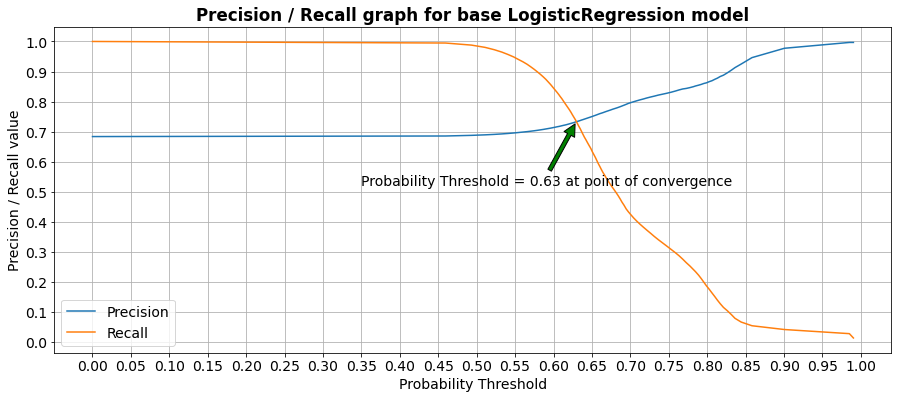

CPU times: user 377 ms, sys: 2.07 ms, total: 380 ms
Wall time: 412 ms


In [55]:
%%time
# Let us also visualize the Precision-Recall graph for the base model predicted results

rbt = test_results.recallByThreshold.toPandas()
pbt = test_results.precisionByThreshold.toPandas()

plt.figure(figsize=(15,6))
plt.title(label='Precision / Recall graph for base LogisticRegression model', fontdict=dict(fontweight='bold'))
plt.plot('threshold', 'precision', data=pbt)
plt.plot('threshold', 'recall', data=rbt)
plt.legend(['Precision', 'Recall'])
plt.xlabel('Probability Threshold')
plt.ylabel('Precision / Recall value')
plt.locator_params(axis='y', nbins=20)
plt.locator_params(axis='x', nbins=40)
plt.annotate(text='Probability Threshold = 0.63 at point of convergence', xy=(0.63,0.735), xytext=(0.35,0.52),
             arrowprops = dict(facecolor='green', shrink=0.05),)
plt.grid()
plt.show()

__*From the base LogisticRegression model Precision/Recall graph, we can see that the two metric values converge approximately at probability value = 0.63, which can then be considered as the optimum point for the cutoff probability threshold.*__

### Updated model, if any
Repeat the steps 

__*From above test results, we can see that RecallByLabel = [0.035069313586685275, 0.9853016642734399] which is excellent for the Positive class but fares poorly for the Negative class classification. We will accordingly re-train the LogisticRegression model with hyperparameter-tuning the Probability Threshold with a value of 0.63 as seen from the Precision/Recall graph.*__

In [56]:
# Building the model

lr2 = LogisticRegression(featuresCol='features', labelCol='is_purchased', maxIter=10, threshold=0.63)

In [57]:
%%time
# Fitting the model on transformed df

model2 = lr2.fit(df_train)

CPU times: user 14.5 ms, sys: 4.41 ms, total: 18.9 ms
Wall time: 14.3 s


In [58]:
%%time
test_results2 = model2.evaluate(df_test)

CPU times: user 1.23 ms, sys: 133 µs, total: 1.37 ms
Wall time: 201 ms


In [59]:
%%time
accuracy = test_results2.accuracy
print('Test data Accuracy =', accuracy)

Test data Accuracy = 0.6351784713859786
CPU times: user 3.92 ms, sys: 424 µs, total: 4.35 ms
Wall time: 16.7 s


In [60]:
%%time
precisionByLabel = test_results2.precisionByLabel
print('Test data PrecisionByLabel =', precisionByLabel)

Test data PrecisionByLabel = [0.42311991869918697, 0.7335212223468531]
CPU times: user 3.37 ms, sys: 364 µs, total: 3.74 ms
Wall time: 8.23 s


In [61]:
%%time
recallByLabel = test_results2.recallByLabel
print('Test data RecallByLabel =', recallByLabel)

Test data RecallByLabel = [0.42408099656742415, 0.7327511122619524]
CPU times: user 0 ns, sys: 2.7 ms, total: 2.7 ms
Wall time: 4.47 ms


In [62]:
F1_score = (2 * precisionByLabel[1] * recallByLabel[1]) / (precisionByLabel[1] + recallByLabel[1])
print('Test data F1_score =', F1_score)

Test data F1_score = 0.73313596506723


In [63]:
%%time
areaUnderROC = test_results2.areaUnderROC
print('Test data ROC_AUC =', areaUnderROC)

Test data ROC_AUC = 0.633965520575469
CPU times: user 2.83 ms, sys: 306 µs, total: 3.14 ms
Wall time: 9.53 s


In [67]:
# Collate all the model evaluation metrics
logisticRegressionMetrics = [{'ModelType'    : 'LogisticRegression',
                              'Accuracy'     : accuracy,
                              'Precision'    : precisionByLabel[1],
                              'Recall'       : recallByLabel[1],
                              'F1_score'     : F1_score,
                              'AreaUnderROC' : areaUnderROC}]
  
# Convert the metrics to a Pandas dataframe 
logisticRegressionMetrics_df = pd.DataFrame(logisticRegressionMetrics)

# Save the dataframe as csv for future model comparison
logisticRegressionMetrics_df.to_csv('logisticRegressionMetrics.csv')

logisticRegressionMetrics_df

,ModelType,Accuracy,Precision,Recall,F1_score,AreaUnderROC
0,LogisticRegression,0.6352,0.7335,0.7328,0.7331,0.6340


### Evaluation metrics for LogisticRegression Model :
1. Accuracy = 0.6351784713859786
2. Precision = 0.7335212223468531<br>
3. Recall = 0.7327511122619524<br>
4. F1_score = 0.73313596506723<br>
5. AreaUnderROC = 0.633965520575469<br>
